# Multi-Layer Perceptron - Wisconsin Breast Cancer dataset.

**Wisconsin Breast Cancer** dataset collects features of the cell cores present in images calculated from a digitalized image of a fine needle aspirate of a breast mass. In this notebook we will use a **Multi-Layer Perceptron** to classify between benign and malignant cells. We already know the dataset of the *Logistic Regression* notebook, so we are not going to carry out an Exploratory Analysis to obtain the data insights. For solving this type of problems, it is necessary to follow a process of loading, transforming, shaping, scaling and partitioning the data:

In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils      import to_categorical
from sklearn.model_selection import train_test_split

data = pd.read_csv("cancer.csv")  # Load the dataset from the .csv file with pandas

Y = data.iloc[:,1:2]  # Select all target values
X = data.iloc[:,2:32]  # Select all features

print(data['diagnosis'].value_counts())  # Check if there is an imbalance between classes

Y = data['diagnosis'].map(lambda diag: 1 if diag == "M" else 0)  # Transform target values to int

X, Y = X.as_matrix(), Y.as_matrix()  # Convert the dataframes to its Numpy-array representations

B    357
M    212
Name: diagnosis, dtype: int64


At this point, we have exactly all the data needed to train the model. But first, we have to **scale** the features using ***sklearn.model_selection***, transform the labels to **one-hot**, and **split** our images into *training data* (70%) and *validation data* (30%):

In [0]:
from tensorflow.keras.utils      import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Y = to_categorical(Y, 2)  # One-hot encoding the labels: [1,0] or [0,1]

scaler = preprocessing.MinMaxScaler()  # Min-Max scaling
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3)  # Partitioning in training and test data

Now, we design our model with **Keras**. We use the Multi-Layer Perceptron architecture that has experimentally achieved a better accuracy among all the carried out tests. Unlike the architecture used with **MNIST**, where it was necessary to classify among 10 categorical labels, in this case a a **binary classification** has to be performed. Therefore, we will not use the *softmax* activation function in the output layer and *categorical_crossentropy* as loss function, but rather we will use ***sigmoid*** as activation function of the output layer and as a *binary_crossentrop **texto en negrita**y* loss function. In addition, we will use ***Dropout*** and ***Batch Normalization*** as **regularization techniques** (with the aim of preventing *overfitting*).

In [0]:
import tensorflow as tf
from tensorflow.keras.layers     import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

mlp = tf.keras.Sequential()

mlp.add(Dense(128, activation='relu'))  # Input layer
mlp.add(BatchNormalization())
mlp.add(Dropout(0.2))
mlp.add(Dense(64, activation='relu'))  # Hidden layer
mlp.add(BatchNormalization())
mlp.add(Dropout(0.2))
mlp.add(Dense(32, activation='relu'))  # Hidden layer
mlp.add(BatchNormalization())
mlp.add(Dropout(0.1))
mlp.add(Dense(8, activation='relu'))  # Hidden layer
mlp.add(BatchNormalization())
mlp.add(Dropout(0.1))
mlp.add(Dense(2, activation='sigmoid'))  # Output layer


mlp.compile(loss='binary_crossentropy',  # binary_crossentropy loss function to predict 2 categorical labels
              optimizer=tf.keras.optimizers.Adam(),  # Combines the advantages of two SGD algorithms: AdaGrad and RMSProp
              metrics=['acc'])

In [0]:
mlp_info = mlp.fit(X_train, Y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 398 samples, validate on 171 samples
Epoch 1/50
398/398 [==============================] - 2s 5ms/step - loss: 0.6754 - acc: 0.6118 - val_loss: 0.6449 - val_acc: 0.6667
Epoch 2/50
398/398 [==============================] - 0s 441us/step - loss: 0.6349 - acc: 0.6658 - val_loss: 0.5816 - val_acc: 0.6901
Epoch 3/50
398/398 [==============================] - 0s 424us/step - loss: 0.5734 - acc: 0.6947 - val_loss: 0.4910 - val_acc: 0.8246
Epoch 4/50
398/398 [==============================] - 0s 450us/step - loss: 0.4919 - acc: 0.8568 - val_loss: 0.3991 - val_acc: 0.9415
Epoch 5/50
398/398 [==============================] - 0s 417us/step - loss: 0.3928 - acc: 0.9221 - val_loss: 0.3210 - val_acc: 0.9181
Epoch 6/50
398/398 [==============================] - 0s 422us/step - loss: 0.2887 - acc: 0.9397 - val_loss: 0.1953 - val_acc: 0.9649
Epoch 7/50
398/398 [==============================] - 0s 434us/step - loss: 0.1873 - acc: 0.9573 - val_loss: 0.1327 - val_acc: 0.9766
Epoch 8/50
398/398

The model achieved **98.25%** of  **validation accuracy**, as can be appreciated in the following figures:

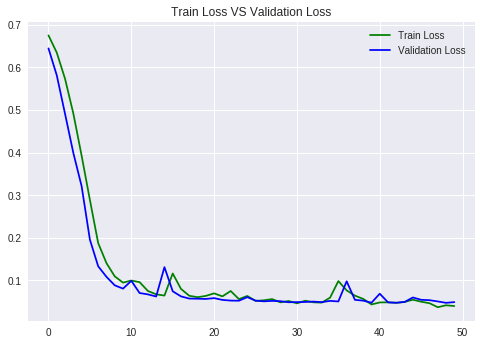

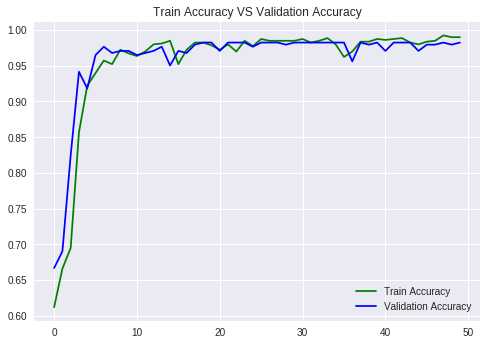

In [0]:
plt.title("Train Loss VS Validation Loss")
plt.plot(mlp_info.history['loss'],     c='g')
plt.plot(mlp_info.history['val_loss'], c='b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

plt.title("Train Accuracy VS Validation Accuracy")
plt.plot(mlp_info.history['acc'],     c='g')
plt.plot(mlp_info.history['val_acc'], c='b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()

Additionally, we can visualize the robustness of the model through the **confusion matrix**, which compares the original labels with the model predictions:

Accuracy: 98.25 %
The model predicted a false malignant 2 times (1.16959 %) and a false benign 1 times (0.5848 %)


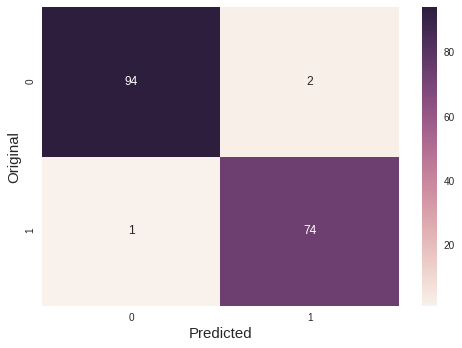

In [0]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

score = mlp.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: {:5.2f} %" .format(score[1] * 100))

Y_pred = mlp.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)  # Decode one-hot label into integers 0 (benign) and 1 (malignant)
Y_orig = np.argmax(Y_test, axis=1)

matConf = confusion_matrix(Y_orig, Y_pred)

falsePositive = round(((matConf[0][1])/float(Y_test.shape[0]))*100, 5)  # Calculate falsePositive %
falseNegative = round(((matConf[1][0])/float(Y_test.shape[0]))*100, 5)  # Calculate falseNegative %

print(f'The model predicted a false malignant {matConf[0][1]} times ({falsePositive} %) and a false benign {matConf[1][0]} times ({falseNegative} %)')

ax = sb.heatmap(matConf, annot=True, fmt=".0f")  # Plot the confusion matrix
ax.set_ylabel('Original', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
plt.show()

Note that there is a slight improvement in the quality of the predictions of the Neural Network model compared to the Logistic Regression model. That the difference between both is not very large depends on the fact that the data set is reduced, since only 569 instances are provided. However, Neural Networks models tend to outperform Logistic Regression models when working with much longer and more complex data.